# Lec4 統計の基礎

## 講義の内容
- 統計とは
  - 母集団と標本
  - 記述統計量
  - 正規分布、様々な確率分布
- 推定
  - 点推定、区間推定と信頼区間
- 仮説検定
  - 帰無仮説、対立仮設、有意水準、相関


統計分布について一通り確率密度関数から検定までが実装されている．scipy.statsを使います。

参考：
https://github.com/rasbt/data-science-tutorial

## 要約統計量 (Summary Statistics) 

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

Irisデータセットをロードし、'sepal_length'(がく片の長さ cm)の分布をヒストグラムで確かめます。

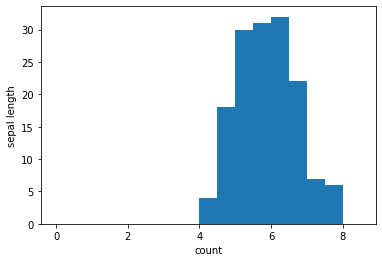

In [4]:
# read dataset
df = pd.read_csv('./datasets/iris/iris.csv')

def histo():
    # create histogram
    bin_edges = np.arange(0, df['sepal_length'].max() + 1, 0.5)
    fig = plt.hist(df['sepal_length'], bins=bin_edges)

    # add plot labels
    plt.xlabel('count')
    plt.ylabel('sepal length')
    
    
histo()

'sepal_length'の方がfloat64であることを確かめます。(N.A等が入ってないかどうか)

In [5]:
x = df['sepal_length'].values
x.dtype

dtype('float64')

平均を計算します

In [6]:
sum(i for i in x) / len(x)

5.843333333333335

numpyのmean/0関数でも計算できますが、値は同じではありませんん。

In [7]:
x_mean = np.mean(x)
x_mean

5.843333333333334

ヒストグラムに、平均の線（縦線）を重ね書きします。

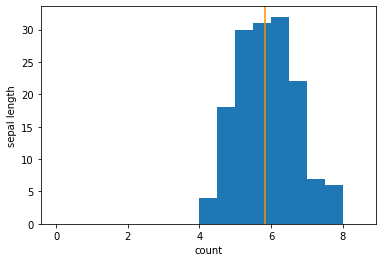

In [8]:
histo()
plt.axvline(x_mean, color='darkorange')

分散を計算します。最初は、公式どおりに計算します


In [9]:
sum([(i - x_mean)**2 for i in x]) / (len(x) - 1)

0.6856935123042504

numpyのvar/2を使っても計算できます。ddofは

Bessel's correction(nの代わりにn-1で割ること)を考慮している

In [9]:
var = np.var(x, ddof=1)
var

0.6856935123042507

In [10]:
df['sepal_length'].var() # note that Bessel's correction is the default

0.6856935123042507

それでは平均±分散を縦線で重ねます

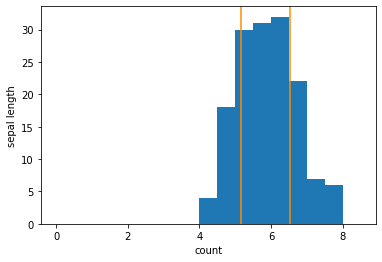

In [11]:
histo()
plt.axvline(x_mean + var, color='darkorange')
plt.axvline(x_mean - var, color='darkorange')

標準偏差：

　numpyのstd関数でも計算できます。Bessel's correction が入ってます

In [12]:
(sum([(i - x_mean)**2 for i in x]) / (len(x) - 1))**0.5

0.8280661279778628

In [13]:
np.sqrt(np.var(x, ddof=1))

0.828066127977863

In [14]:
std = np.std(x, ddof=1)
std

0.828066127977863

In [15]:
df['sepal_length'].std() # note that Bessel's correction is the default

0.828066127977863

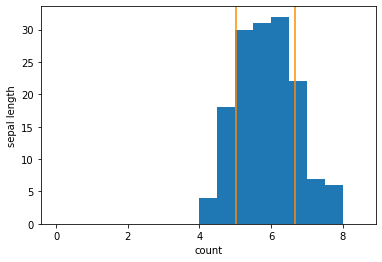

In [16]:
histo()
plt.axvline(x_mean + std, color='darkorange')
plt.axvline(x_mean - std, color='darkorange')

Min/Max

In [17]:
np.min(x),np.max(x)

(4.3, 7.9)

モード（最頻値):

いったんlistに変換すると list.count(値)で、その値をもつデータ数を数え上げられます

関数 max(set(list_name), key = list_name.count) は、指定されたリストで最大回数発生する要素を返します。

In [18]:
lst = list(x)
mode = max(set(lst), key=lst.count)
mode

5.0

最頻値に何個データがあったか、

In [21]:
lst.count(mode)

10

stasのmode関数でも求められます

In [22]:
stats.mode(x)

ModeResult(mode=array([5.]), count=array([10]))

25パーセント点と75パーセント点:

- まずはxをソートしてyを得ます
- y.shape[0]は、yの要素数を返します。要素数の25%/75&のところの値を得ます

In [26]:
y = np.sort(x)
percentile_25th = y[round(0.25 * y.shape[0]) + 1]
percentile_25th

5.1

In [27]:
percentile_75th = y[round(0.75 * y.shape[0]) - 1]
percentile_75th

6.4

numpyのpercentile関数を使ってもば求まります。

In [25]:
np.percentile(x, q=[25, 75], interpolation='lower')

C:\Users\miwam\AppData\Local\Temp\ipykernel_19692\1784253322.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  np.percentile(x, q=[25, 75], interpolation='lower')


array([5.1, 6.4])

pandasのDataFrameのquntile関数を使っても求められます

In [29]:
df['sepal_length'].quantile(0.25, interpolation='lower')

5.1

In [30]:
df['sepal_length'].quantile(0.75, interpolation='lower')

6.4

25パーセント点と75パーセント点をプロットしてみます

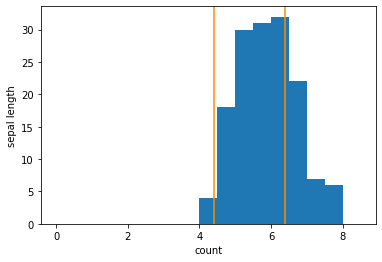

In [31]:
histo()
plt.axvline(percentile_75th, color='darkorange')
plt.axvline(percentile_25th - var, color='darkorange')

中央値 (50パーセント点でもある):

In [32]:
x = np.sort(x)

tmp = round(0.5 * x.shape[0])

if x.shape[0] % 2:
    median = x[tmp - 1]
else:
    median = x[tmp - 1] + (x[tmp] - x[tmp - 1]) / 2.
    
median

5.8

numpyにはmedian関数がある

In [33]:
np.median(x)

5.8

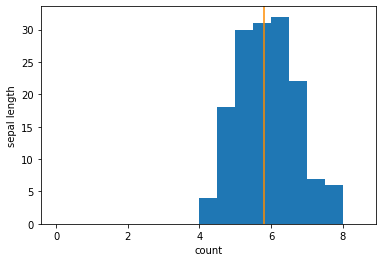

In [31]:
histo()
plt.axvline(median, color='darkorange')

## 仮説検定入門
hypothesis-testing_1.ipynb　より

### Case 1 -- 並べ替え(permutating)サンプリングによる、帰無仮説に基づいたシミュレーションの利用 (2-sample test)
- 2標本間の平均値差の検定（並べ替え検定)
- 帰無仮説: ２分布の間での平均は同一である(「2 つの母集団は同じもの
である」）
- 2分布の平均には差がある（経験的平均）
- 帰無仮説が正しいならば、経験的平均は確率的にそうなったに違ない、じゃあ、この平均の差はどれぐらいの確率で起こるものなのかを計算する。
- データを並べ替えて (permute the data) ２つに分けて違いがあるかどうかを検証する。(帰無仮説に基づいて新しいデータを生成しているともいえる)
- 参考：https://www.mizumot.com/files/permutation.pdf

Irisデータを使う。setosaとversicolorのsepal_widthのリストを得る(x1,x2)

In [34]:
df = pd.read_csv('./datasets/iris/iris.csv')
x1 = df.loc[df['species'] == 'setosa', 'sepal_width'].values
x2 = df.loc[df['species'] == 'versicolor', 'sepal_width'].values

In [35]:
for d in (x1, x2):
    print('Mean:', np.mean(d))
    print('Std.Dev.:', np.std(d, ddof=1))

Mean: 3.428
Std.Dev.: 0.3790643690962887
Mean: 2.7700000000000005
Std.Dev.: 0.3137983233784114


the difference in means (our test statistic) of permuted samples should be zero if the null hypothesis is true

２つのサンプル集合をくっつけて、並べ替えて、２つに分割して返します。

In [36]:
def generate_permutation_samples(sample1, sample2, seed=None):
    rng = np.random.RandomState(seed)
    sample = np.concatenate((sample1, sample2))
    sample_perm = rng.permutation(sample)
    sample1_perm = sample_perm[:sample1.shape[0]]
    sample2_perm = sample_perm[sample1.shape[0]:]
    return sample1_perm, sample2_perm

x1,x2から並び替えを行いx1_perm,x2_permを得てこの差を perm_mean_diffsの要素として格納することを1000回行う。

In [37]:
num_permutations = 1000

perm_mean_diffs = np.zeros(num_permutations)
for i in range(num_permutations):
    x1_perm, x2_perm = generate_permutation_samples(x1, x2, seed=i)
    perm_mean_diffs[i] = np.mean(x1_perm) - np.mean(x2_perm)

経験的平均の差をもとめる。差がある

In [41]:
empirical_mean_diff = np.mean(x1) - np.mean(x2)
empirical_mean_diff

0.6579999999999995

経験的なへ近の差は、確率的にそれが得られたものとすると、じゃあ、そうじゃないデータを前提（帰無仮説）とすると経験的平均の差はどれだけ、ありえないのかを検定する。

perm_mean_diffsの分布（リサンプリングした２つの分布の平均の差の分布）と、経験的平均（オレンジ）の重ね書きで可視化する

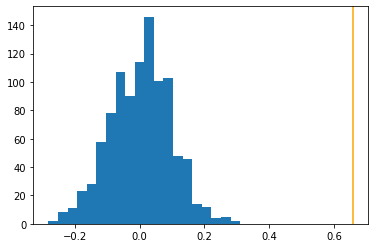

In [42]:
plt.hist(perm_mean_diffs, bins=20)
plt.axvline(empirical_mean_diff, color='orange')

p値は、、0.0である

In [43]:
p_value = np.sum(perm_mean_diffs >= empirical_mean_diff) / len(perm_mean_diffs)
print('P-value', p_value)

P-value 0.0


- 経験的平均(オレンジの縦線)から左（あるいは右）の領域がp値である
- オレンジの縦線から右の領域の面積が0.0であるから、帰無仮説が正しいならば、標本の平均の差を観測する可能性もっと極端なことは0%らしい、ことがわかる。
- すなわち、帰無仮説はrejectされる。帰無仮説が正しければ、ここで観測が期待されるより、統計的に優位に異なるデータが得られるはずである

### Case 2 -- ブートストラップ法(bootstraping)による、帰無仮説に基づいたシミュレーションの利用 (1-sample test)


In [41]:
df = pd.read_csv('./datasets/iris/iris.csv')
x1 = df.loc[df['species'] == 'setosa', 'sepal_width'].values
x1_mean = np.mean(x1)
x1_mean

3.428

- 帰無仮説：x1とx2は同じ平均値を持つ（分布は同じとは限らない）
- x2からは標本データは得られず、平均だけが得られるとする
- 有意水準を$\alpha=0.05$とする

In [45]:
x2_mean = 3.55

1. x1を正規化し、x2と同じ平均を持つようにする
2. ブートストラップされたレプリカを得る
3. p値を計算

In [50]:
# 1) normalize x1 so that it has the same mean as x2
normed_x1 = x1 - np.mean(x1) + x2_mean

# 2) draw bootstrap replicates
def bootstrap_means(x, n_bootstrap_samples, seed=None):

    rng = np.random.RandomState(seed)
    sample_means = np.zeros(shape=n_bootstrap_samples)
    
    for i in range(n_bootstrap_samples):
        boot_sample = rng.choice(x, size=x.shape[0], replace=True)
        # replicate is a general term for a statistic computed
        # from a bootstrap sample
        bootstrap_replicate = np.mean(boot_sample)
        sample_means[i] = bootstrap_replicate
    return sample_means

num_replicates = 1000
bs_replicates = bootstrap_means(x1, n_bootstrap_samples=num_replicates, seed=123)

# 3) compute p-value
p_value = np.sum(bs_replicates >= x2_mean) / num_replicates

print('p-value', p_value)

p-value 0.006


at $\alpha=0.005$, we can reject the null hypothesis that the two variables are from the same distribtion

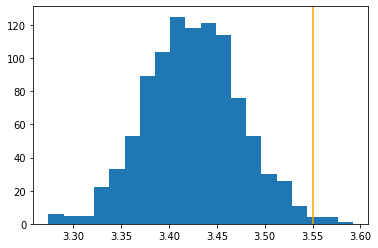

In [48]:
plt.hist(bs_replicates, bins=20)
plt.axvline(x2_mean, color='orange')

## 分布の件

# 正規分布を知る

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy.stats
from scipy.stats import norm  # normal distribution, 正規分布

import matplotlib.pyplot as plt
%matplotlib inline

FLAG_fig = True

正規分布のグラフ pdf（probability density function）

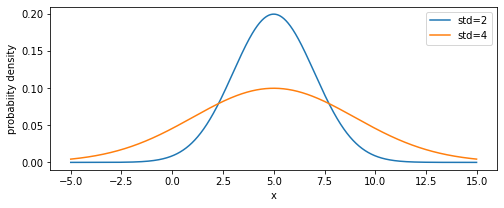

In [3]:
m = 5   # 平均値
std = 2 # 標準偏差
std2 = 4
x = np.arange( -5, 15, 0.01)
y = norm.pdf(x, loc=m, scale=std)
y2 = norm.pdf(x, loc=m, scale=std2)
#y = (1 / np.sqrt(2 * np.pi * std*std ) ) * np.exp(-(x-m) ** 2 / (2 * std*std) ) #正規分布の式

fig = plt.subplots(figsize=(8,3))
plt.plot(x,y,label='std=2')
plt.plot(x,y2,label='std=4')
plt.xlabel('x')
plt.ylabel('probabiity density')
plt.legend()
if FLAG_fig: plt.savefig('fig_PROB_NormalDist.png')

#### パーセント点と確率の計算
パーセント点（pp:percent point)$z_{\alpha}$ を求めるには，$1-\alpha$をppf ( percent point function )に与える。<br>
確率を求めるには，パーセント点$z_{\alpha}$をcdf (cumulative density function)　に与える。<br>
なお，標準正規分布（平均値 $m = 0$,  標準偏差 $\sigma=1$ ）を対象とする<br>

#### 片側の場合
標準正規分布$N(0,1)$のグラフで，$z_{\alpha} \le x < \infty$ の確率 $\alpha$（面積）をユーザが与える。このとき，  
$- \infty < x \le z_{\alpha} $の確率（面積）は $1-\alpha$となる。
この値をscipy.stats.norm.ppf に与えれば，$z_{\alpha}$が求まる。

In [4]:
m = 0
std = 1
alpha = 0.05
prob = 1 - alpha
z_alp = norm.ppf(prob, loc=m, scale=std)
print('パーセント点＝', z_alp) #

パーセント点＝ 1.6448536269514722


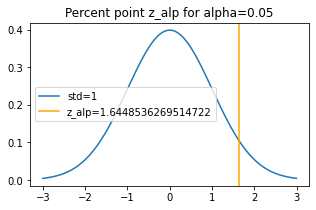

In [19]:
# グラフ書いてみるよ
m = 0
std = 1
alpha = 0.05

x = np.arange( -3, 3, 0.01)
y = norm.pdf(x, loc=m, scale=std)

fig = plt.subplots(figsize=(5,3))
plt.plot(x,y,label='std=1')

prob = 1 - alpha
z_alp = norm.ppf(prob, loc=m, scale=std)
plt.axvline(z_alp, color='orange',label="z_alp={0}".format(z_alp))
plt.title("Percent point z_alp for alpha=0.05")
plt.legend()
if FLAG_fig: plt.savefig('fig_PROB_PercentPoint.png')

isf (Inverse survival function，生存関数の逆関数）を用いると，1-alphaの計算が不要で，上記と同じパーセント点を得る

In [52]:
z_alp2 = norm.isf(alpha, loc=m, scale=std)
print('isfを用いたパーセント点', z_alp2)

isfを用いたパーセント点 1.6448536269514729


In [53]:
m = 0
std = 1.0
z_alp = 1.96
prob = norm.cdf(z_alp, loc=m, scale=std)
print('確率＝',prob)

確率＝ 0.9750021048517795


#### 両側の場合
区間[a b]の確率を求める。
1. $- \infty < x \le z_{b} $の確率$P_a$を求める  
2. $- \infty < x \le z_{a} $の確率$P_b$を求める
3. $P_a - P_b$を計算

In [54]:
za = 1.65
zb = -1.65
pa = norm.cdf(za, loc=0, scale=1) # loc is mean
pb = norm.cdf(zb, loc=0, scale=1) # scale is standard deviation
p = pa - pb
print('p=',p)

p= 0.9010570639327038


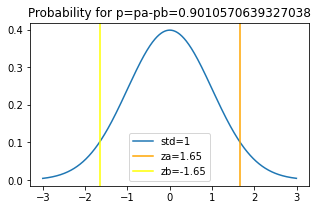

In [20]:
# グラフ書いてみるよ
za = 1.65
zb = -1.65
x = np.arange( -3, 3, 0.01)
y = norm.pdf(x, loc=0, scale=1)

fig = plt.subplots(figsize=(5,3))
plt.plot(x,y,label='std=1')

pa = norm.cdf(za, loc=0, scale=1) # loc is mean
pb = norm.cdf(zb, loc=0, scale=1) # scale is standard deviation
p = pa - pb

plt.axvline(za, color='orange',label="za={0}".format(za))
plt.axvline(zb, color='yellow',label="zb={0}".format(zb))
plt.title("Probability for p=pa-pb={0}".format(p))
plt.legend()
if FLAG_fig: plt.savefig('fig_PROB_ProbFromPercentPoint.png')

#### 検定では，$\alpha$が初めに与えられる。
これに基づき，片側（z_alp），両側（za, zb）を求めることが多い。  
片側の場合は既に述べた。  
両側の場合，正規分布が対称で，かつ，（za, zb）が原点を中心とした左右対称という前提があり，この場合，intervalを用いることができる。<br>
下記の例では，両側にz_alp/2=0.025 があり，この二つを足して0.05となることに留意。

In [55]:
za,zb = norm.interval(alpha=0.95, loc=0, scale=1)
print('za=',za,'  zb=',zb)

za= -1.959963984540054   zb= 1.959963984540054


横軸が $x$,  縦軸が頻度（データ数Nが多いほど，縦軸のスケールも大きくなる）<br>
・平均値を中心とした分布となる<br>
・データ数100程度では，正規分布の形とは言えず，データ数を非常に多くして，ようやく理想形に近くなる<br>
・標本平均値，標本標準偏差もデータ数がかなり多くないと，真値に近づかない<br>
・標準偏差の計算 x.std(ddof=1) のddof=1は“不偏標準偏差”を求めるとき，すなわち，1/(N-1)という除算を行う<br>
・このddofを指定しないと， 1/N を用いた計算を行い，不偏とならない<br>
・標準偏差はばらつきの指標となる

N = 100  mean = 2.081327  std = 3.401773e+00


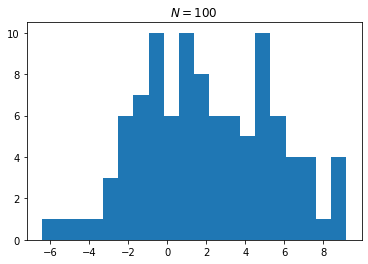

In [58]:
np.random.seed(123) # scipyと共通，乱数発生の再現性を得る

mean = 2.0 # mean, 平均値
std = 3.0  # standar deviation, 標準偏差
#for N in [100, 10000]:
for N in [100]:
    x = scipy.stats.norm.rvs(loc=mean, scale=std, size=N) # rvs:Random variates
    print('N = %d  mean = %f  std = %e' % (N, x.mean(), x.std(ddof=1))) 
    plt.figure()
    plt.hist(x, bins=20)
    plt.title('$N = %i$' % (N) )

if FLAG_fig: plt.savefig('fig_PROB_NormalDist_Sim100.png')
plt.show()

#### 中心極限定理
一様乱数を用いる，この区間[a,b]の平均値は$\mu = \frac{a+b}{2}$, 分散$\sigma^2 = \frac{(b-a)^2}{12}$である。
このn個（幾つかの値）の標本平均をN個（これは一定とする）発生させ，その分布を見ると，正規分布$N(\mu, \sigma^2/n )$に近づく。ここでは，標準正規分布に正規化する。
他の分布でも試してみられたい。

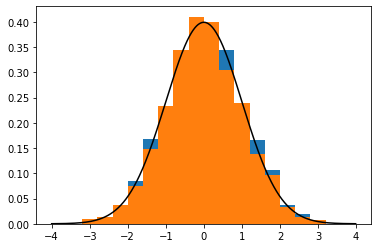

In [57]:
N = 2000
y= np.zeros(N)
for n in [5, 5000]:
    for i in range(N):
        x = scipy.stats.uniform.rvs(size=n)
        y[i] = (x.mean() - 1/2)/(np.sqrt(1/12)/np.sqrt(n))
    plt.hist(y, bins=20, range=(-4,4), density=True)

xx = np.arange(-4, 4, 0.01)
nrm = scipy.stats.norm.pdf(xx, loc=0.0, scale=1.0 )
plt.plot(xx, nrm, c='k')

if FLAG_fig: plt.savefig('fig_PROB_NormalDist_Climt.png')

### ポアソン分布
$$
P(X=k) = \exp (-\lambda t) \frac{(\lambda t)^k}{k !}
$$
scipy.stats.poisson  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html

In [59]:
# -*- coding: utf-8 -*-
import numpy as np
from scipy.stats import poisson
from scipy.stats import uniform

import matplotlib.pyplot as plt
%matplotlib inline

FLAG_fig = True

### 確率質量関数（pmf: Probability mass function）のグラフ
離散確率変数の場合の呼称 ，連続確率変数の場合は確率密度関数 (pdf: Probability density function)

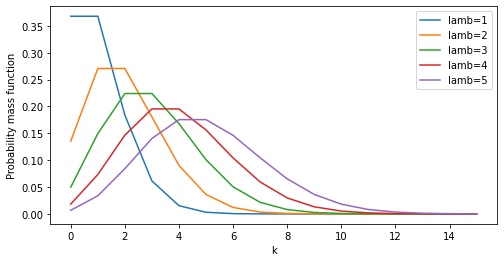

In [60]:
fig = plt.subplots(figsize=(8,4))
k = np.arange(0,16)

for lamb in range(1,6):
    p = poisson.pmf(k, lamb)
    plt.plot(k, p, label='lamb='+str(lamb))

plt.xlabel('k')
plt.ylabel('Probability mass function')
plt.legend()

if FLAG_fig: plt.savefig('fig_PROB_Poisson_pmf_Plot')

#### 例：交通事故問題
交通事故　平均2.4件／日のとき，交通事故が2件／日　以下となる確率を求める。

In [61]:
lamb = 2.4
psum = 0
for k in [0, 1, 2]:
    p = poisson.pmf(k, mu=lamb)
    psum = psum + p
print('sum of p =',psum)

sum of p = 0.5697087466575105


#### ポアソン到着モデル
$$ 
  t_{arrive} = -\frac{1}{\lambda} \log_{e} P_{arrive} (T) 
$$

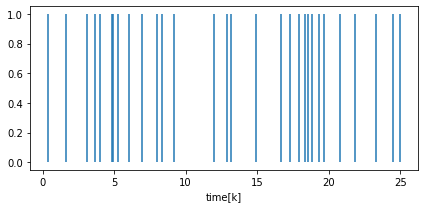

In [62]:
np.random.seed(123)

Num=30 # 　Num人分の到着時刻を得る
t_arrive = np.zeros(Num)
lamb = 1

sum = 0.0
for i in range(Num):
    sum = sum - (1/lamb) * np.log( uniform.rvs(size=1) )
    t_arrive[i] = sum

fig, ax = plt.subplots(figsize=(6,3))
ax.vlines(t_arrive, ymin=0, ymax=1)
ax.set_xlabel('time[k]')
plt.tight_layout() 

if FLAG_fig: plt.savefig('fig_PROB_Poisson_Arrival')

In [63]:
t_arrive

array([ 0.36173173,  1.61300813,  3.096468  ,  3.69191736,  4.02115924,
        4.88129069,  4.90071391,  5.27929894,  6.01132853,  6.94752223,
        8.0170282 ,  8.33304156,  9.15727229, 11.97606585, 12.89725794,
       13.20107562, 14.90212604, 16.64251721, 17.27447263, 17.90590856,
       18.36098266, 18.52417029, 18.84650547, 19.33912531, 19.66424154,
       20.7944717 , 21.81116677, 23.28842256, 24.51357118, 24.97405843])

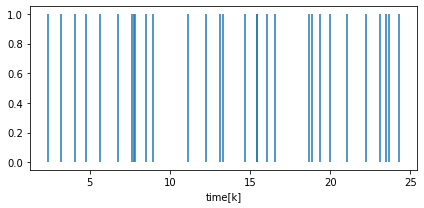

In [64]:
Num=30 # the number of arraivl, Num人分の到着時刻を得る
t_arrive = np.zeros(Num)
lamb = 1

sum = 0.0
for i in range(Num):
    sum = sum - (1/lamb) * np.log( uniform.rvs(size=1) )
    t_arrive[i] = sum

fig, ax = plt.subplots(figsize=(6,3))
ax.vlines(t_arrive, ymin=0, ymax=1)
ax.set_xlabel('time[k]')
plt.tight_layout() 

if FLAG_fig: plt.savefig('fig_PROB_Poisson_Arrival')

## 平均値の検定　（母分散が未知） t検定
$$
t = \frac{\hat{\mu} - \mu_0}{\sqrt{\sigma^2 \big/ N}}
$$
上記の$t$検定量は自由度$ df = N - 1 $の$t$分布に従う（ $df$: Degree of Freedom）<br>
scipy.stats.t https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html <br>

In [21]:
# -*- coding: utf-8 -*-

import numpy as np
import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

FLAG_fig = True

#### 例１：あるクラス，テストの平均点と補講の効用（片側検定）

In [22]:
data = np.array([1, -1, -2, 3, -1, 5, 4, 0, 7, -1])
m = np.average(data) # mean
s = np.std(data, ddof=1) # std, ddof=1 : unbiased
N = len(data) # the number of sample
print(m,s,N)

1.5 3.064129385141706 10


In [23]:
alp = 0.05
# 自由度N-1のt分布で、alphaに対するパーセント点を求める(1-alpa)をppf(percent point function)に入れて求める->talp
talp = stats.t.ppf((1-alp),N-1)
print('talp (alpha=0.05, df=%d) =%f' %((N-1),talp))

m0 = 0 # null hypothesis
# 母関数の平均が0が帰無仮説
# t値は、は talpより大？小？
t = (m-m0)/(s/np.sqrt(N))
print('t=', t)

talp (alpha=0.05, df=9) =1.833113
t= 1.5480470613460082


talp > t より，H0は棄却できない。
通常は，talp, t のようなpp(percent point)を求めるよりは，
p値(p value)を求める。これを次に示す

In [24]:
prob = stats.t.cdf(t,N-1)
print('p value=',1-prob)

p value= 0.07800883831234118


有意水準を0.05 とおくと，これよりp valueの方が大きいので，H0を棄却できない。

#### 例2：精密部品の直径（両側検定）

In [48]:
data2 = np.array([1.5399, 1.5390, 1.5399, 1.5395, 1.5400, 1.5390, 1.5399, 1.5399])
m = np.mean(data2)        # mean
s = np.std(data2, ddof=1) # std, ddof=1 : unbiased
N = len(data2)            # 
df = N - 1               # DoF (degree of freedom)
m0 = 1.54                 # H0 (null hypothesis)
print('sample mean =',m,'  std = ',s,' The number of data = ',N)

sample mean = 1.5396375   std =  0.00042067123233509513  The number of data =  8


In [54]:
t = (m-m0)/(s/np.sqrt(N))   # サンプルから求まるpp値
prob = stats.t.cdf(t, df)
if t >=  0:
    p = 1 - prob
else:
    p = prob

print('t = ',t)
print('p value =',2*p)

t =  -2.4373067467182707
p value = 0.04493615922381196


In [53]:
data2 = np.array([1.5399, 1.5390, 1.5399, 1.5395, 1.5400, 1.5390, 1.5399, 1.5399])
m = np.mean(data2)        # mean
s = np.std(data2, ddof=1) # std, ddof=1 : unbiased
m0=1.54
N = len(data2) 
t = (m-m0)/(s/np.sqrt(N))   # サンプルから求まるpp値
prob = stats.t.cdf(t, N-1)
p= (1-prob) if t >= 0 else prob
pvalue=2*p
pvalue

0.04493615922381196

In [52]:
prob,t,m,s

(1.0348676552358357e-26, -10354.35142053983, 0, 0.00042067123233509513)

注意：上記のように，tが負の値をとるときは，p = prob とする。  
$\alpha=0.05$と置くならば，p value $< \alpha$ よりH0を棄却

実は，次の関数を用いると計算は楽<br>
t, p = scipy.stats.ttest_1samp(data, m0)<br>
data: 1群のサンプルデータ<br>
m0: 帰無仮説H0で仮定した平均値<br>
t: t値<br>
p: p値，両側検定を前提としている。片側検定ではこの半分の値を用いる<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html

In [27]:
t, p = stats.ttest_1samp(data2, m0)
print('t = ',t)
print('both side p = ',p)
print('one  side p = ',p/2)

t =  -2.4373067467182707
both side p =  0.04493615922381196
one  side p =  0.02246807961190598
